<a href="https://colab.research.google.com/github/mhuertascompany/DL_ED127_2020/blob/master/tutorials/day5/VAE_Star_Galaxy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Unsupervised Star-Galaxy Separation

The goal of this tutorial is to build an unsupervised star-galaxy separation using Convolutional Variational Auto-Encoders. 

We train a convolutional autoencoder (CVAE) with stamps of images of stars and galaxies (without any labels). We then explore the latent space learned by the CVAE and check tha the CVAE has learned that there were 2 different populations in the dataset.

The dataset used for training is taken from COSMOS.

---



#### Before we start, make sure to open this Colab notebook in "PlayGround Mode" (top left) and to change the Runtime type to GPU by navigating to the toolbar and clicking Runtime -> Change runtime type and then changing Hardware accelerator to GPU

---

In [2]:
import os
import sys
import tarfile
from urllib.request import urlretrieve
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_datasets as tfds


import numpy as np
import matplotlib.pyplot as plt
import pdb
import umap

import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data download and preparation

Before mounting the drive click on [this folder](https://drive.google.com/drive/folders/1PcftgBzBySo1Ync-Wdsp9arTCJ_MfEPE?usp=sharing) and add it to your google drive by following these steps:

*   Go to your drive 
*   Find shared folder ("Shared with me" link)
*   Right click it
*   Click Add to My Drive



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load data

In [0]:
pathinData="/content/drive/My Drive/EDE2019/star-galaxy"


# donwload feature vector and labels
X_ML = np.load(pathinData+'/x_train.npy')
#morphological class
Y_ML = np.load(pathinData+'/y_train.npy') 
#X_ML=X_ML-np.min(X_ML)
#print(X_ML.min())
#X_ML=X_ML/np.max(X_ML)
X_ML=(X_ML[:,30-14:30+14,30-14:30+14,:])

for i in range(len(X_ML)):
  X_ML[i,:,:]=(X_ML[i,:,:]-np.mean(X_ML[i,:,:]))/np.std(X_ML[i,:,:])

x_train=X_ML[0:int(len(X_ML)*4/5),:,:]
x_test=X_ML[int(len(X_ML)*4/5)::,:,:]

y_train=Y_ML[0:int(len(X_ML)*4/5)]
y_test=Y_ML[int(len(X_ML)*4/5)::]

### Plot some random example
Run multiple times to see more than one example. Class0 are stars, Class1 are galaxies.

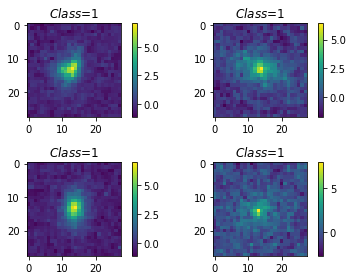

In [9]:
randomized_inds_train = np.random.permutation(len(x_train))

fig = plt.figure()
for i,j in zip(randomized_inds_train[0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  im = ax.imshow(X_ML[i,:,:,0])
  plt.title('$Class$='+str(y_train[i]))
  fig.tight_layout() 
  fig.colorbar(im)

## Model Setup

The following cells set up the model in TensorFlow. We have set up a very basic Convolutional Encoder-Decoder. It does not perform super well for this problem. I encourage you to try to modify this network to achieve better results. You should in particular try to reduce more the dimension of the bottleneck (end of encoder).

In [0]:
def pack_images(images, rows, cols):
    """Helper utility to make a field of images."""
    shape = tf.shape(images)
    width = shape[-3]
    height = shape[-2]
    depth = shape[-1]
    images = tf.reshape(images, (-1, width, height, depth))
    batch = tf.shape(images)[0]
    rows = tf.minimum(rows, batch)
    cols = tf.minimum(batch // rows, cols)
    images = images[:rows * cols]
    images = tf.reshape(images, (rows, cols, width, height, depth))
    images = tf.transpose(images, [0, 2, 1, 3, 4])
    images = tf.reshape(images, [1, rows * width, cols * height, depth])
    return images


def image_tile_summary(name, tensor, rows=8, cols=8):
    tf.summary.image(name, pack_images(tensor, rows, cols), max_outputs=1)


input_shape = (28,28,1)
encoded_size = 16  # THIS IS THE SIZE OF THE BOTTLENECK --> FEEL FREE TO CHANGE
# AND EXPLORE
base_depth = 32


prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    #tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfkl.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior,weight=0.6)),
])



decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=None),
    tfkl.Flatten(),
    
    tfkl.Dense(tfpl.IndependentNormal.params_size(input_shape),activation=None),
    #tfpl.IndependentNormal(input_shape, tfd.Normal.mean),
    tfpl.IndependentNormal(input_shape, tfd.Normal.sample),
    #tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits),
])


vae = tfk.Model(inputs=encoder.inputs,outputs=decoder(encoder.outputs[0]))



def cae_model():

    #Parameters of the model that can be modified
    nfilters=16
    
    
    input_layer=tfkl.InputLayer(input_shape=input_shape)

    # Convolutional Layer #1
    conv1 = tf.keras.layers.Conv2D(
      32,
      (3, 3),
      padding="same",
      activation=tf.nn.relu)(input_layer)
    
    #pooling
    pool1 = tf.keras.layers.MaxPooling2D((2,2))(conv1)
    
    #Convolutional Layer #2
    conv2 = tf.keras.layers.Conv2D(
      64,
      (3, 3),
      padding="same",
      activation=tf.nn.relu)(pool1)
    
    #pooling  
    pool2=tf.keras.layers.MaxPooling2D((2,2))(conv2)
    
    #Convolutional Layer #2
    conv3 = tf.keras.layers.Conv2D(
      8,
      (3, 3),
      padding="same",
      activation=tf.nn.relu)(pool2)
    
    #pooling  
    pool3=tf.keras.layers.MaxPooling2D((3,3))(conv3)
    

    # Deconvolutional Layer #1
    deconv1 = tf.keras.layers.Conv2DTranspose(
      8,
      (3,3), 
      padding="same",
      strides=(3,3),
      activation=tf.nn.relu)(pool3)
    
    deconv2 = tf.keras.layers.Conv2DTranspose(
      64,
      (3,3), 
      padding="same",
      strides=(2,2),
      activation=tf.nn.relu)(deconv1)
    
    output = tf.keras.layers.Conv2DTranspose(
      1,
      (3,3), 
      padding="same",
      strides=(2,2),
      activation=tf.nn.relu)(deconv2)

    return tfk.Model(input_layer,output_layer)  
       




## Training the model

In [0]:
#Define output path - This folder will contain the trained model
pathout='star-galaxy/models/vae1'

#Set RESET=True to delete all previous runs of the same model
RESET=False
if RESET:
  tf.summary.FileWriterCache.clear()
  os.system("rm -rf "+ pathout)

Train first for 1000 steps. This is just a trick to run TensorBoard on the notebook and follow the training.

In [14]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negloglik)

hist = vae.fit(x_train,x_train,epochs=20)


Epoch 1/20
187/187 [==============================] - 2s 12ms/step - loss: 583.8691
Epoch 2/20
187/187 [==============================] - 2s 11ms/step - loss: 426.4614
Epoch 3/20
187/187 [==============================] - 2s 11ms/step - loss: 401.9234
Epoch 4/20
187/187 [==============================] - 2s 11ms/step - loss: 395.0179
Epoch 5/20
187/187 [==============================] - 2s 11ms/step - loss: 355.4839
Epoch 6/20
187/187 [==============================] - 2s 11ms/step - loss: 354.9939
Epoch 7/20
187/187 [==============================] - 2s 11ms/step - loss: 337.5934
Epoch 8/20
187/187 [==============================] - 2s 11ms/step - loss: 327.3497
Epoch 9/20
187/187 [==============================] - 2s 11ms/step - loss: 323.0688
Epoch 10/20
187/187 [==============================] - 2s 11ms/step - loss: 311.4478
Epoch 11/20
187/187 [==============================] - 2s 11ms/step - loss: 303.9607
Epoch 12/20
187/187 [==============================] - 2s 11ms/step - loss

## Predictions and evaluation

In [18]:
#predict 10 examples

xhat = vae(x_test[0:10])
assert isinstance(xhat, tfd.Distribution)

print(x_test.shape)
pdb.set_trace()

(1489, 28, 28, 1)
--Call--
> /usr/local/lib/python3.6/dist-packages/IPython/core/displayhook.py(236)__call__()
-> def __call__(self, result=None):
(Pdb) print(xhat.sample().shape)
*** NameError: name 'xhat' is not defined
(Pdb) c


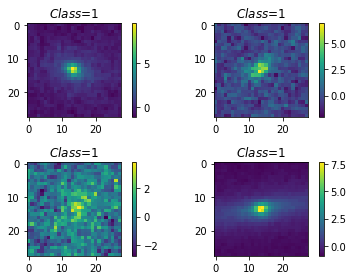

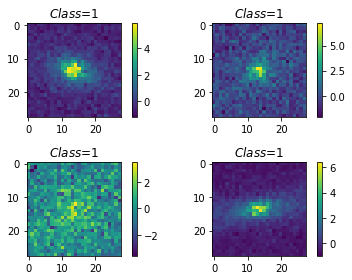

In [20]:
fig = plt.figure()
for i,j in zip(range(10),range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  im = ax.imshow(x_test[i,:,:,0])
  plt.title('$Class$='+str(y_test[i]))
  fig.tight_layout() 
  fig.colorbar(im)

fig = plt.figure()
for i,j in zip(range(10),range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  im = ax.imshow(xhat.sample()[i,:,:,0])
  plt.title('$Class$='+str(y_test[i]))
  fig.tight_layout() 
  fig.colorbar(im)

In [0]:
# Now, let's generate ten never-before-seen galaxies and stars.
z = prior.sample(10)
xtilde = decoder(z)
assert isinstance(xtilde, tfd.Distribution)

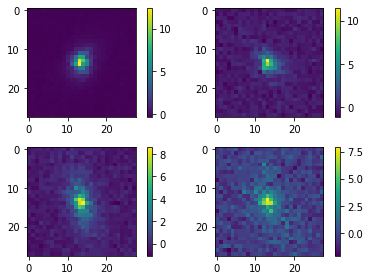

In [24]:
fig = plt.figure()
for i,j in zip(range(10),range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  im = ax.imshow(xtilde.sample()[i,:,:,0])
  fig.tight_layout() 
  fig.colorbar(im)

Run TensorBoard. You should see an orange panel appearing. If it's not the case, try again running the cell. 

## Visualizing the feature space

How would you do to visualize the feature space?
You need to call the encoder for a given image and sample from it...



Explore the latent space with UMAP